In [5]:
# call %matplotlib only in a Jupiter notebook
%matplotlib inline 

# Common and local imports
import dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

# Prerequisites

* **OpenCV:** We use openCV to read images of cats/Dogs so you will have to install it. <br /><br />

* **Shape function:** If you have multi-dimensional Tensor in TF, you can get the shape of it by doing this:

In [6]:
a = tf.truncated_normal([16,128,128,3])
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(tf.shape(a)))

[ 16 128 128   3]


In [7]:
# Reshape "a" into 2D Tensor with shape Array([16, 49152])
with tf.Session() as sess:
    b=tf.reshape(a, [16,49152])
    print(sess.run(tf.shape(b)))

[   16 49152]


>***Note:*** We have collapse the last 3 dimentions into 1 single dimention. 

> $$ 49152 = (128\times 128\times 3) $$ 



[]

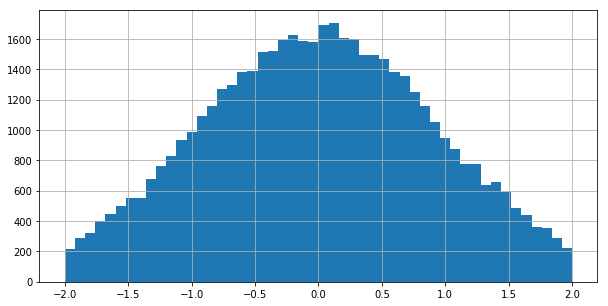

In [8]:
# Lets user Pandas DataFrame to see how this looks!
sess = tf.Session()
b_pd = pd.DataFrame(sess.run(b))
sess.close() # Remember to always close the session!
b_pd.iloc[1, :].hist(bins=50, figsize=(10, 5))
plt.plot()

>***Note:*** That's a beautifull normal distribution!  :')

> *Continuation of Prerequisites*

* **Softmax:** is a function that converts K-dimensional vector ‘x’ containing real values to the same shaped vector of real values in the range of (0,1), whose sum is 1. We shall apply the softmax function to the output of our convolutional neural network in order to, convert the output to the probability for each class.

$$ o(x)_{j} = \frac{ e^{x_{i}} }{\ \sum_{n=1}^N e^{x_{i}}\ } 
                \bigg \} \ j = 1 \dotsc N  $$

> This is a type of *normalization*. This one in particular is also called [*normalized exponential function*](https://en.wikipedia.org/wiki/Softmax_function)



# Reading inputs

I have used 2000 images of dogs and cats each from [Kaggle dataset](https://www.kaggle.com/c/dogs-vs-cats) but you could use any n image folders on your computer which contain different kinds of objects. Typically, we divide our input data into 3 parts:

1. ***Training data:*** we shall use 80% i.e. 0 images for training. <br /><br />

1. ***Validation data:*** 20% images will be used for validation. These images are taken out of training data to calculate accuracy independently during the training process. <br /><br />

1. ***Test set:*** separate independent data for testing which has around 400 images. Sometimes due to something called Overfitting; after training, neural networks start working very well on the training data(and very similar images) i.e. the cost becomes very small, but they fail to work well for other images. For example, if you are training a classifier between dogs and cats and you get training data from someone who takes all images with white backgrounds. It’s possible that your network works very well on this validation data-set, but if you try to run it on an image with a cluttered background, it will most likely fail. So, that’s why we try to get our test-set from an independent source.

In [9]:
classes = ['dogs', 'cats']
num_classes = len(classes)
 
train_path='training_data'

# validation split
validation_size = 0.2

# 128 x 128 RGB image
img_size = 128

# RGB images have 3 channels
num_channels = 3

# batch size
batch_size = 16
 
data = dataset.read_train_sets(train_path, img_size, classes, validation_size=validation_size)

print(data)

Going to read training images
Now going to read dogs files (Index: 0)
Now going to read cats files (Index: 1)
<dataset.read_train_sets.<locals>.DataSets object at 0x7f6ca8e82048>


> dataset is a class that the author created to facilitate reading the input data. This is a simple python code that reads images from the provided training and testing data folders.

The objective of our training is to learn the correct values of weights/biases for all the neurons in the network that work to do classification between dog and cat. **The Initial value of these weights be anything, but it works better if you take normal distributions (with mean zero and small variance)**. There are other methods to initialize the network but normal distribution is more prevalent. 

Now, let’s define functions to create the initial weights quickly just by specifying the shape.

In [10]:
def create_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def create_biases(size):
    return tf.Variable(tf.constant(0.05, shape=[size]))

# Creating network layers

## Building convolution layer in TensorFlow

**`tf.nn.conv2d`** function can be used to build a convolutional layer which takes these inputs:

* **input** = the output(activation) from the previous layer. This should be a 4-D tensor. Typically, in the first convolutional layer, you pass n images of size **`width * height * num_channels`**, then this has the size `[n width height num_channels]` <br /> <br />

* **filter** = trainable variables defining the filter. We start with a random normal distribution and learn these weights. It’s a 4D tensor whose specific shape is predefined as part of network design. If your filter is of size `filter_size` and input fed has `num_input_channels` and you have `num_filters` filters in your current layer, then filter will have following shape: 

    * `[filter_size, filter_size, num_input_channels, num_filters]`<br /> <br />

* **strides** = defines how much you move your filter when doing convolution. In this function, it needs to be a Tensor of **`size>=4`** i.e. **`[batch_stride x_stride y_stride depth_stride]`**. batch_stride is always 1 as you don’t want to skip images in your batch. `x_stride` and `y_stride` are same mostly and the choice is part of network design and we shall use them as 1 in our example. `depth_stride` is always set as 1 as you don’t skip along the depth. <br /> <br />

* **padding** = SAME means we shall 0 pad the input such a way that output `x,y` dimensions are same as that of input. <br /> <br />

After convolution, we add the biases of that neuron, which are also learnable/trainable. Again we start with random normal distribution and learn these values during training.

Now, we apply max-pooling using `tf.nn.max_pool` function that has a very similar signature as that of `conv2d` function.

In [11]:
def create_convolutional_layer(input,
                               num_input_channels,
                               conv_filter_size,
                               num_filters):
    
    ## We shall define the weights that will be trained using create_weights function.
    weights = create_weights(shape=[conv_filter_size, conv_filter_size, num_input_channels, num_filters])
    
    ## We create biases using the create_biases function. These are also trained.
    biases = create_biases(num_filters)

    ## Creating the convolutional layer
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    layer += biases

    ## We shall be using max-pooling.  
    layer = tf.nn.max_pool(value=layer,
                            ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME')
    ## Output of pooling is fed to Relu which is the activation function for us.
    layer = tf.nn.relu(layer)

    return layer

## Flattening layer

The Output of a convolutional layer is a multi-dimensional Tensor. We want to convert this into a one-dimensional tensor. This is done in the Flattening layer. We simply use the reshape operation to create a single dimensional tensor as defined below:

In [12]:
def create_flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer = tf.reshape(layer, [-1, num_features])
    return layer

> <p>`num_elements()` just multiplies the values within the specified indexes.</p>

> <p>Ex: <br /> `shape([ 2 5 10 ]).num_elements()` would return `(2 * 5 * 10)` where as <br /> `shape([ 2 5 10 ])[1:2].num_elements()` would return `( 2 * 5 )`</p>
    

# Fully connected layer

Now, let’s define a function to create a fully connected layer. Just like any other layer, we declare weights and biases as random normal distributions. In fully connected layer, we take all the inputs, do the standard z=wx+b operation on it. Also sometimes you would want to add a non-linearity(RELU) to it. So, let’s add a condition that allows the caller to add RELU to the layer.

In [13]:
def create_fc_layer(input,          
                    num_inputs,    
                    num_outputs,
                    use_relu=True):
    
    #Let's define trainable weights and biases.
    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(num_outputs)
 
    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
 
    return layer

# Placeholders and input

Now, let’s create a placeholder that will hold the input training images. All the input images are read in dataset.py file and resized to 128 x 128 x 3 size. Input placeholder x is created in the shape of [None, 128, 128, 3]. The first dimension being None means you can pass any number of images to it. For this program, we shall pass images in the batch of 16 i.e. shape will be [16 128 128 3]. Similarly, we create a placeholder y_true for storing the predictions. For each image, we have two outputs i.e. probabilities for each class. Hence y_pred is of the shape [None 2] (for batch size 16 it will be [16 2].

In [14]:
# The images themself
x = tf.placeholder(tf.float32, 
                   shape=[None, img_size,img_size, num_channels], 
                   name='x')

# Real label for the image
y_true = tf.placeholder(tf.float32, 
                        shape=[None, num_classes], 
                        name='y_true')

# Predicted label for the image
y_true_cls = tf.argmax(y_true, axis=1)

# Network design

We use the functions defined above to create various layers of the network.

In [15]:
# Network graph params
filter_size_conv1 = 3 
num_filters_conv1 = 32

filter_size_conv2 = 3
num_filters_conv2 = 32

filter_size_conv3 = 3
num_filters_conv3 = 64
    
fc_layer_size = 128

with tf.device('/device:GPU:0'):
    # Define Network
    layer_conv1 = create_convolutional_layer(input=x,
                                             num_input_channels=num_channels,
                                             conv_filter_size=filter_size_conv1,
                                             num_filters=num_filters_conv1)

    layer_conv2 = create_convolutional_layer(input=layer_conv1,
                                             num_input_channels=num_filters_conv1,
                                             conv_filter_size=filter_size_conv2,
                                             num_filters=num_filters_conv2)

    layer_conv3 = create_convolutional_layer(input=layer_conv2,
                                            num_input_channels=num_filters_conv2,
                                            conv_filter_size=filter_size_conv3,
                                            num_filters=num_filters_conv3)

    layer_flat = create_flatten_layer(layer_conv3)

    # fc = Fully Connected
    layer_fc1 = create_fc_layer(input=layer_flat,
                                num_inputs=layer_flat.get_shape()[1:4].num_elements(),
                                num_outputs=fc_layer_size,
                                use_relu=True)

    layer_fc2 = create_fc_layer(input=layer_fc1,
                                num_inputs=fc_layer_size,
                                num_outputs=num_classes,
                                use_relu=False)

    y_pred = tf.nn.softmax(layer_fc2, name="y_pred")

# Predictions

As mentioned above, you can get the probability of each class by applying softmax to the output of fully connected layer.

`y_pred = tf.nn.softmax(layer_fc2,name="y_pred")`

y_pred contains the predicted probability of each class for each input image. The class having higher probability is the prediction of the network. y_pred_cls = tf.argmax(y_pred, dimension=1)

Now, let’s define the cost that will be minimized to reach the optimum value of weights. We will use a simple cost that will be calculated using a Tensorflow function softmax_cross_entropy_with_logits which takes the output of last fully connected layer and actual labels to calculate cross_entropy whose average will give us the cost.

In [16]:
y_pred_cls = tf.argmax(y_pred, axis=1)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

# Optimization

Tensorflow implements most of the optimisation functions. We shall use AdamOptimizer for gradient calculation and weight optimization. We shall specify that we are trying to minimise cost with a learning rate of 0.0001.

`optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)`

As you know, if we run optimizer operation inside session.run(), in order to calculate the value of cost, the whole network will have to be run and we will pass the training images in a feed_dict(Does that make sense? Think about, what variable would you need to calculate cost and keep going up in the code). Training images are passed in a batch of 16(batch_size) in each iteration

In [62]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

We can calculate the validation accuracy by passing accuracy in session.run() and providing validation images in a feed_dict.

`val_acc = session.run(accuracy,feed_dict=feed_dict_validate)`

Similarly, we also report the accuracy for the training images.

`acc = session.run(accuracy, feed_dict=feed_dict_train)`

As, training images along with labels are used for training, so in general training accuracy will be higher than validation. We report training accuracy to know that we are at least moving in the right direction and are at least improving accuracy in the training dataset. After each Epoch, we report the accuracy numbers and save the model using saver object in Tensorflow.

In [18]:
total_iterations = 0
saver = tf.train.Saver()
# saver.save(session, 'dogs-cats-model')

In [19]:
def show_progress(epoch, 
                  feed_dict_train, 
                  feed_dict_validate, 
                  val_loss,
                  session):
    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Training Epoch {0} --- Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%},  Validation Loss: {3:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss))

In [59]:
def train(num_iteration):
    total_iterations = 0
    loss = []
    epochs = []
    accuracy_array = []
    
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:   
        session.run(tf.global_variables_initializer())
        
        for i in range(total_iterations,
                       total_iterations + num_iteration):

            x_batch, y_true_batch, _, cls_batch = data.train.next_batch(batch_size)
            x_valid_batch, y_valid_batch, _, valid_cls_batch = data.valid.next_batch(batch_size)
            
            feed_dict_tr = {
                x: x_batch, 
                y_true: y_true_batch
            }
        
            feed_dict_val = {
                x: x_valid_batch,
                y_true: y_valid_batch
            }

            session.run(optimizer, feed_dict=feed_dict_tr)

            if i % int(data.train.num_examples/batch_size) == 0: 
                val_loss = session.run(cost, feed_dict=feed_dict_val)
                epoch = int(i / int(data.train.num_examples/batch_size))    

                loss.append(val_loss)
                epochs.append(epoch)
                accuracy_array.append(session.run(accuracy, feed_dict=feed_dict_tr))
                
                loss_map = {
                    'loss': loss,
                    'epochs': epochs,
                    'accu': accuracy_array 
                }

#                 if (epoch > 0) and (epoch % 5) == 0:
#                     pd_loss = pd.DataFrame(loss_map)
#                     pd_loss.plot(x="accu", y="loss", kind='line')
#                     plt.show()  
                
                show_progress(epoch, 
                              feed_dict_tr, 
                              feed_dict_val,
                              val_loss,
                              session)

                saver.save(session, './dogs-cats-model') 
                
        total_iterations += num_iteration

In [69]:
# 1 epoch = 50 iterations or (num_of_images/batch)
train(num_iteration=2250)

Training Epoch 1 --- Training Accuracy:  50.0%, Validation Accuracy:  50.0%,  Validation Loss: 0.698
Training Epoch 2 --- Training Accuracy:  50.0%, Validation Accuracy:  56.2%,  Validation Loss: 0.685
Training Epoch 3 --- Training Accuracy:  50.0%, Validation Accuracy:  50.0%,  Validation Loss: 0.700
Training Epoch 4 --- Training Accuracy:  56.2%, Validation Accuracy:  31.2%,  Validation Loss: 0.723
Training Epoch 5 --- Training Accuracy:  62.5%, Validation Accuracy:  62.5%,  Validation Loss: 0.674
Training Epoch 6 --- Training Accuracy:  68.8%, Validation Accuracy:  37.5%,  Validation Loss: 0.727
Training Epoch 7 --- Training Accuracy:  68.8%, Validation Accuracy:  50.0%,  Validation Loss: 0.674
Training Epoch 8 --- Training Accuracy:  62.5%, Validation Accuracy:  56.2%,  Validation Loss: 0.698
Training Epoch 9 --- Training Accuracy:  68.8%, Validation Accuracy:  62.5%,  Validation Loss: 0.646
Training Epoch 10 --- Training Accuracy:  87.5%, Validation Accuracy:  68.8%,  Validation L